# Automated Kernel Density Estimation for extracting Wildlife Vehicle Accidents on Roads

This Notebook describes the python code for extracting Wildlife Vehicle Accident(WVA) Hotspots along roads. The required data sets are the Wildlife Vehicle Accidents (point feature class) and the street (polyline feature class). I would suggest the Open Street Data Set for road calcualtion (https://download.geofabrik.de/europe/germany/bayern.html). As this data set consists out of polyline features a sql-query can help to filter out the wanted street segment (e.g. B20). For further information on WVA and Kernel Density Estimation (KDE) see also this storymap: https://storymaps.arcgis.com/stories/bede15cf99b94570bd88844a78cd2ec0

ArcPy is a Python site package that provides a useful and productive way to perform geographic data analysis, data conversion, data management, and map automation with Python. It is mandantory to import arcpy and usually the first step working with automatisation processes in ArcGISPro.
Automating the full process did not work, as we had problems with the Symbology and could not figure out those steps with ColorRamp. Another issues was the mandatory reclassification into 5 classes. These steps will be explained how to be done in this Notebook as well. 


In [1]:
import arcpy
from arcpy.sa import KernelDensity, ExtractByMask
arcpy.CheckOutExtension("3D")
arcpy.CheckOutExtension("spatial")


The first step is to set a Geodatabase and a workspace. Please change the following paths accordingly. 

In [ ]:
wildlifeGDB = r"C:\Users\felix\OneDrive\Dokumente\ArcGIS\Projects\Final_Assignment\Final_Assignment.gdb"
arcpy.env.workspace = wildlifeGDB
arcpy.env.overwriteOutput = True

These are the input feature layers. Please upload the right data sets into your GDB and select a inputName of your choice which will be used for the final output product. The inputSearchRadius is set to 0.01 which gives back good results but may be changed (e.g. to 0.005) for better results. More information can be found in the KDE-description below. 

In [ ]:
inputStreet = "B20_BGD"
inputAccidents = "WildlifeAccidents_LDK_BGD"
inputName = "choose your name in here "
inputSearchRadius = 0.01

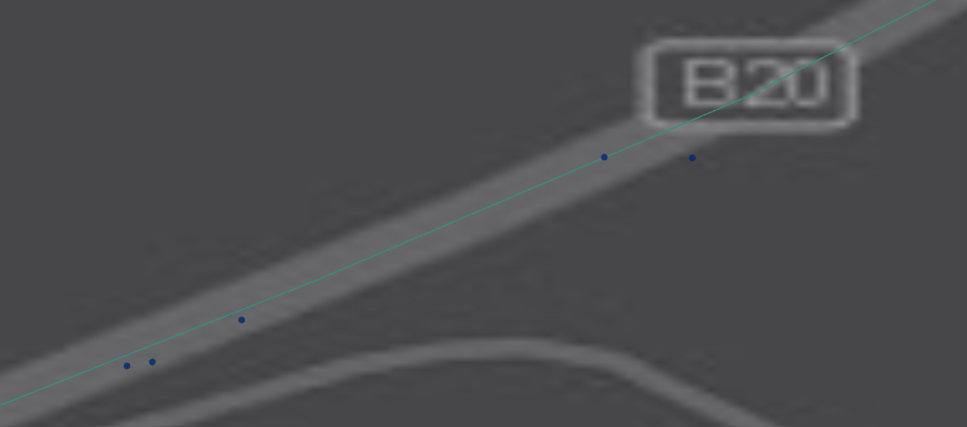

For choosing the right WVA we have to buffer the street. Otherwise due to coordinate inaccuracy the street-polyline (green) will not be intersected with the accidents (blue points) and the according accidents will not be belonging to the street. This would be bad for calculation. The buffer of 400m is set for masking reasons only to make the output eye-friendly. 

In [ ]:
# Buffered inputStreet Dataset in Diameter D_40 + D_400
output_buffer = wildlifeGDB + "\\" + "bufferD40"
buffer_distance = "20 meters"
arcpy.analysis.Buffer(inputStreet, output_buffer, buffer_distance, dissolve_option = "ALL")

# Buffer 400
output_buffer = wildlifeGDB + "\\" + "bufferD400"
buffer_distance = "200 meters"
arcpy.analysis.Buffer(inputStreet, output_buffer, buffer_distance, dissolve_option = "ALL")

After buffering, of course intersecting is important. The next step then is the Kernel Density Estimation. Join_attributes could also be set to "ALL" but "ONLY_FID" is enough. 

In [ ]:
# Intersect inputStreet with all accidents (inputAccidents) to get the accidents lying on the inputStreet
in_features = ["bufferD40", inputAccidents]
out_feature_class = wildlifeGDB + "\\" + "intersectedAccidents"
join_attributes = "ONLY_FID"
output_type = "point"
arcpy.analysis.Intersect(in_features, out_feature_class, join_attributes)

The Kernel Density Estimation is the most important step in all this calculation process and had to be checked several times to choose the right parameters. The in_feature_class are the intersected accidents. Population field is set to "NONE" as every accident counts one. The population field is the count or quantity to be spread across the landscape to create a continuous surface. The search radius is the most important value and represents the distance within to calculate the density. Units are based on the linear unit of the projection of the output spatial reference. A mask of 400m is set as we are just interested in the KDE-values alongside the road. 

In [ ]:
# KERNELFUNCTION
in_features = "intersectedAccidents"
KDE = arcpy.sa.KernelDensity(in_features, population_field="NONE", inputSearchRadius, area_unit_scale_factor="SQUARE_MAP_UNITS", out_cell_values="DENSITIES", method="PLANAR", in_barriers="")

# set a mask over the calculation
KDE = ExtractByMask(KDE, "bufferD400")
KDE.save(wildlifeGDB + "\\" + inputName)
#OUTPUT #1

arcpy.AddMessage("Kernel complete")
arcpy.AddMessage (inputName + " created")

As the output comes out with stretched KDE values image (1) and we would like to have classified Values in 5 classes (2) we tried to use the ApplySymbology function. This function transfers the symbology from a sample Symbology set (sampleSymbology) to the newly created Kernel Density Raster Output. We also tried the ColorRamp function but we had no satifying output-Symbology. As we found no proper solution so far, we wrote two independent scripts and these steps in between have to be done manually. 
Image (1) refers to the created KDE which comes out in "strechted" values and should be transfered to "classified" values (image(2)). Methodology can be set to "Equal Interval" or "Natural Breaks" which does not make a big difference. Five classes are recommended but not mandatory. The suggested Color Scheme is "yellow to red" but depends on the personal preferences. 

#arcpy.ApplySymbologyFromLayer
sampleSymbology = arcpy.Raster("sampleSymbology")
Updated_Symbology = arcpy.management.ApplySymbologyFromLayer(in_layer=KDE, in_symbology_layer=sampleSymbology, symbology_fields=[["VALUE_FIELD", "", ""]], update_symbology="UPDATE")[0]

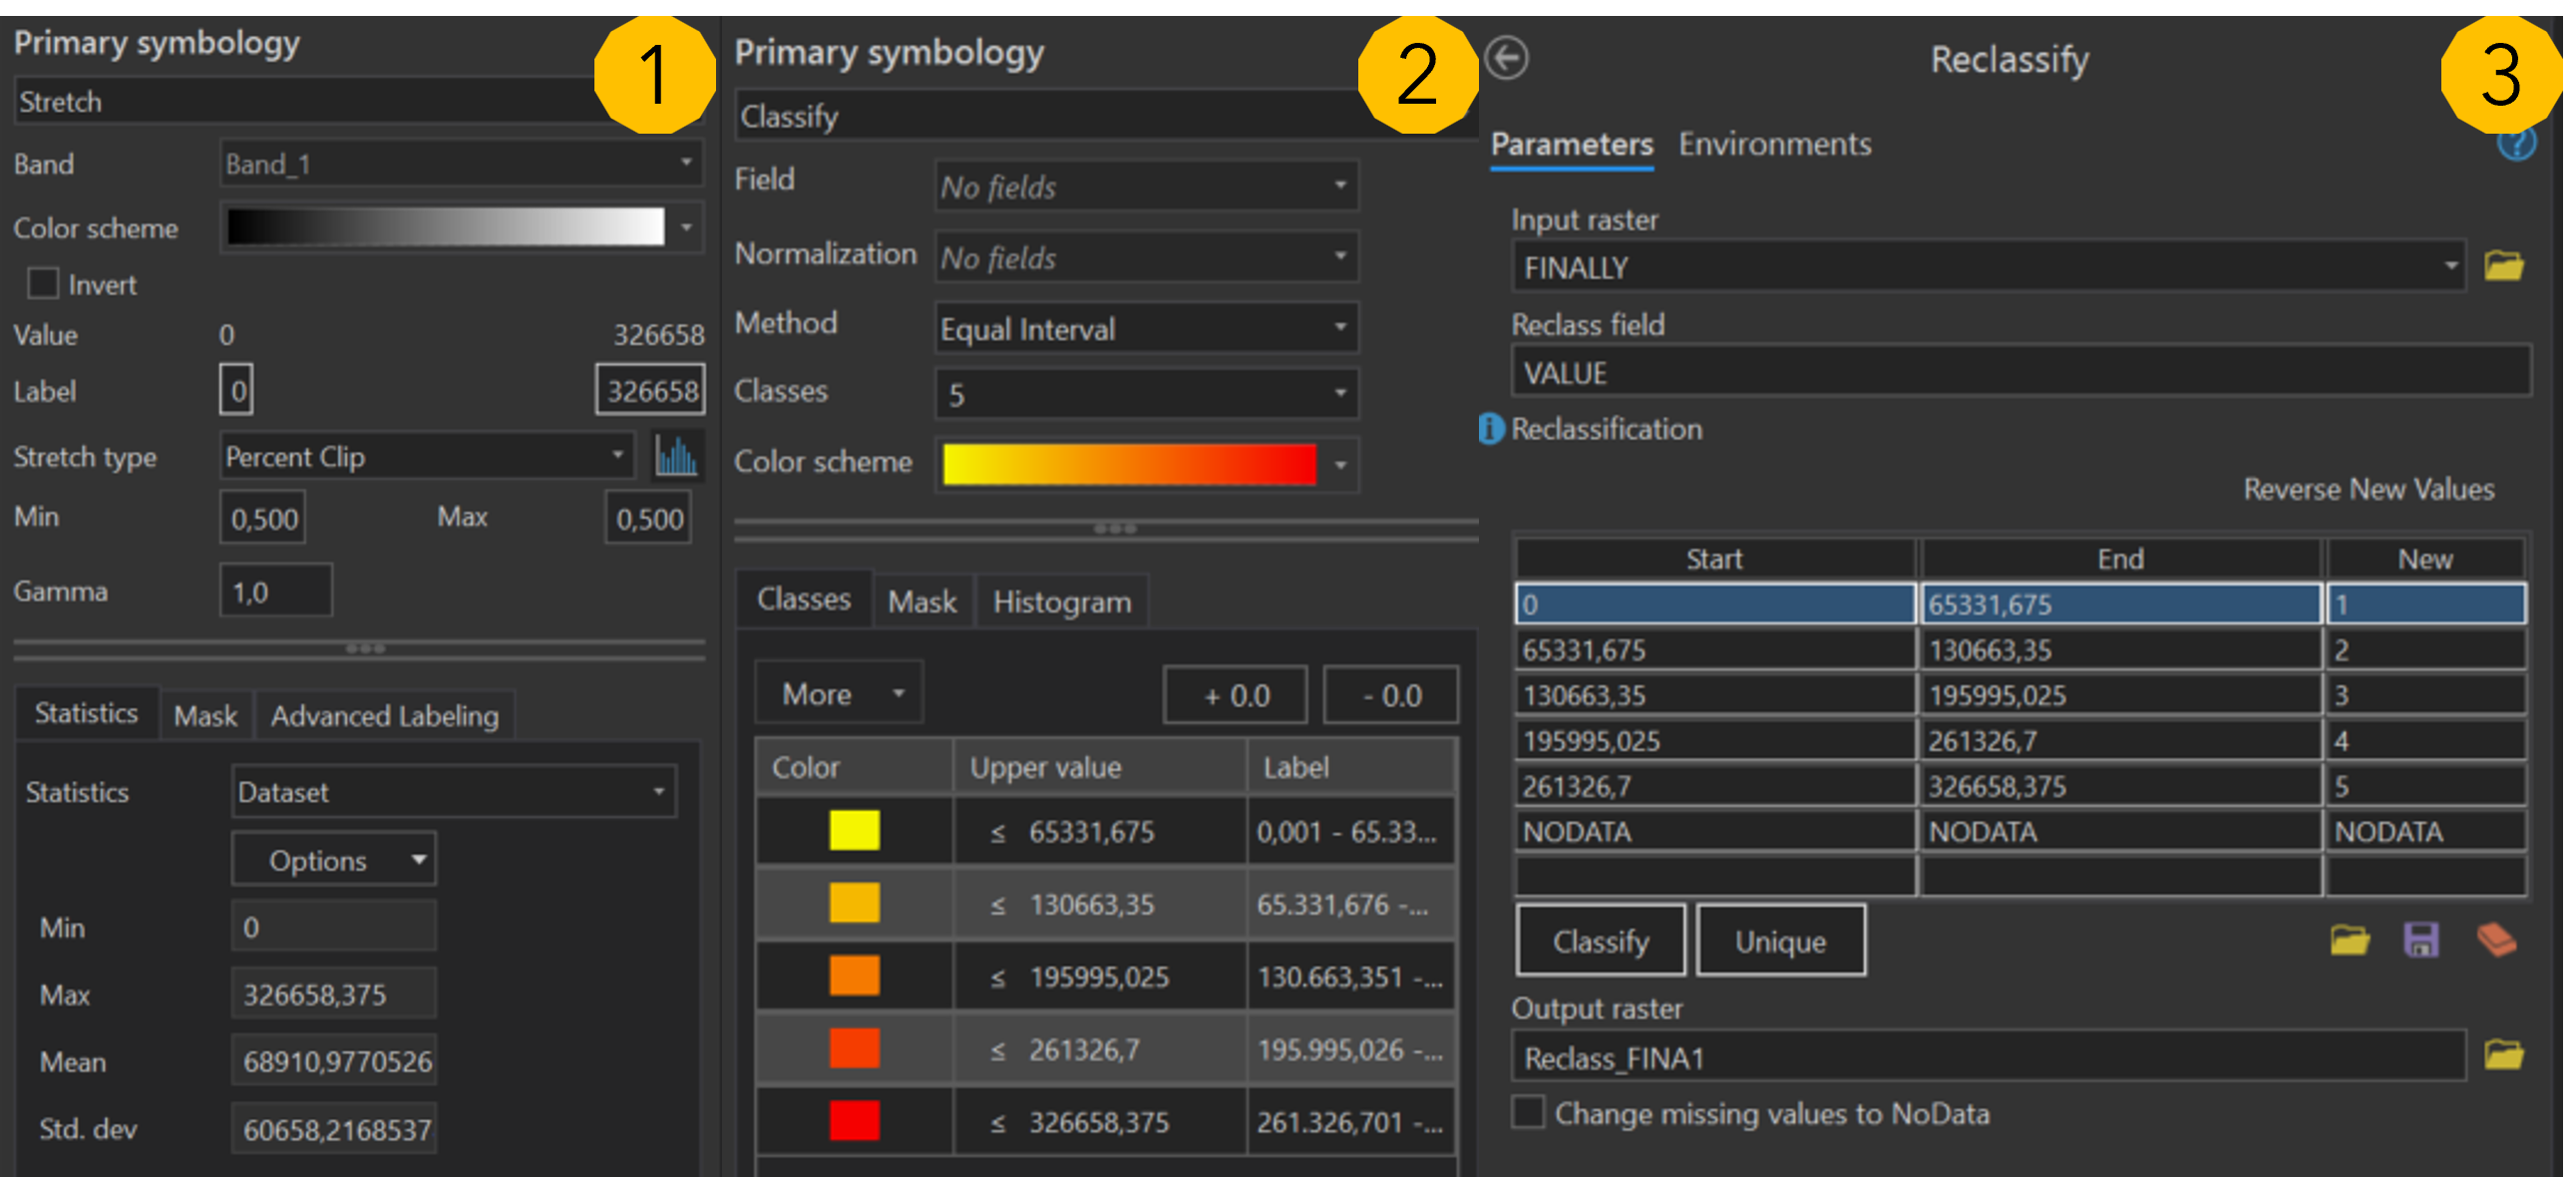

A reclassification is mandatory for intersecting the buffered Street (D40) with the final output. As a raster and a vector layer cannot be instersected we have to transfer the raster to a vector (polygon) data set. Reclassification could work but the mandantory remap-values are problematic and could be solved by mathematical-algorithms to divide the value-range into 5 "Equal Interval" classes. 

Please redo a reclassification as seen in image (3). Reclass Field should be "VALUE".

#Reclassification
Output_raster = wildlifeGDB + "\\" + inputName + "Reclassified"
Reclassify = Output_raster
Output_raster = arcpy.sa.Reclassify(in_raster=Updated_Symbology, reclass_field="VALUE", remap="5656,884277 57692,648788 1;57692,648788 93959,999810 2;93959,999810 129438,930159 3;129438,930159 167283,122530 4;167283,122530 206704,156250 5", missing_values="DATA")
Output_raster.save(Reclassify)

In [ ]:
# Process: Raster to Polygon (Raster to Polygon) (conversion)
Output_polygon_features = wildlifeGDB + "\\" + inputName + "PolygonKDE"
PolygonKDE = Output_polygon_features
arcpy.conversion.RasterToPolygon(in_raster=Output_raster, out_polygon_features=Output_polygon_features, simplify="SIMPLIFY", raster_field="VALUE", create_multipart_features="SINGLE_OUTER_PART", max_vertices_per_feature=None)

The raster to Polygon transformation enables to intersect the buffered street polyline to achieve the final result. 

In [ ]:
# Intersect the just created Polygon with the Buffered Street to get the final Product
in_features = ["bufferD40", Output_polygon_features]
out_feature_class = wildlifeGDB + "\\" + inputName + "intersectedAccidents"
outFeatureClass = out_feature_class
join_attributes = "ALL"
output_type = "point"
arcpy.analysis.Intersect(in_features, out_feature_class, join_attributes)

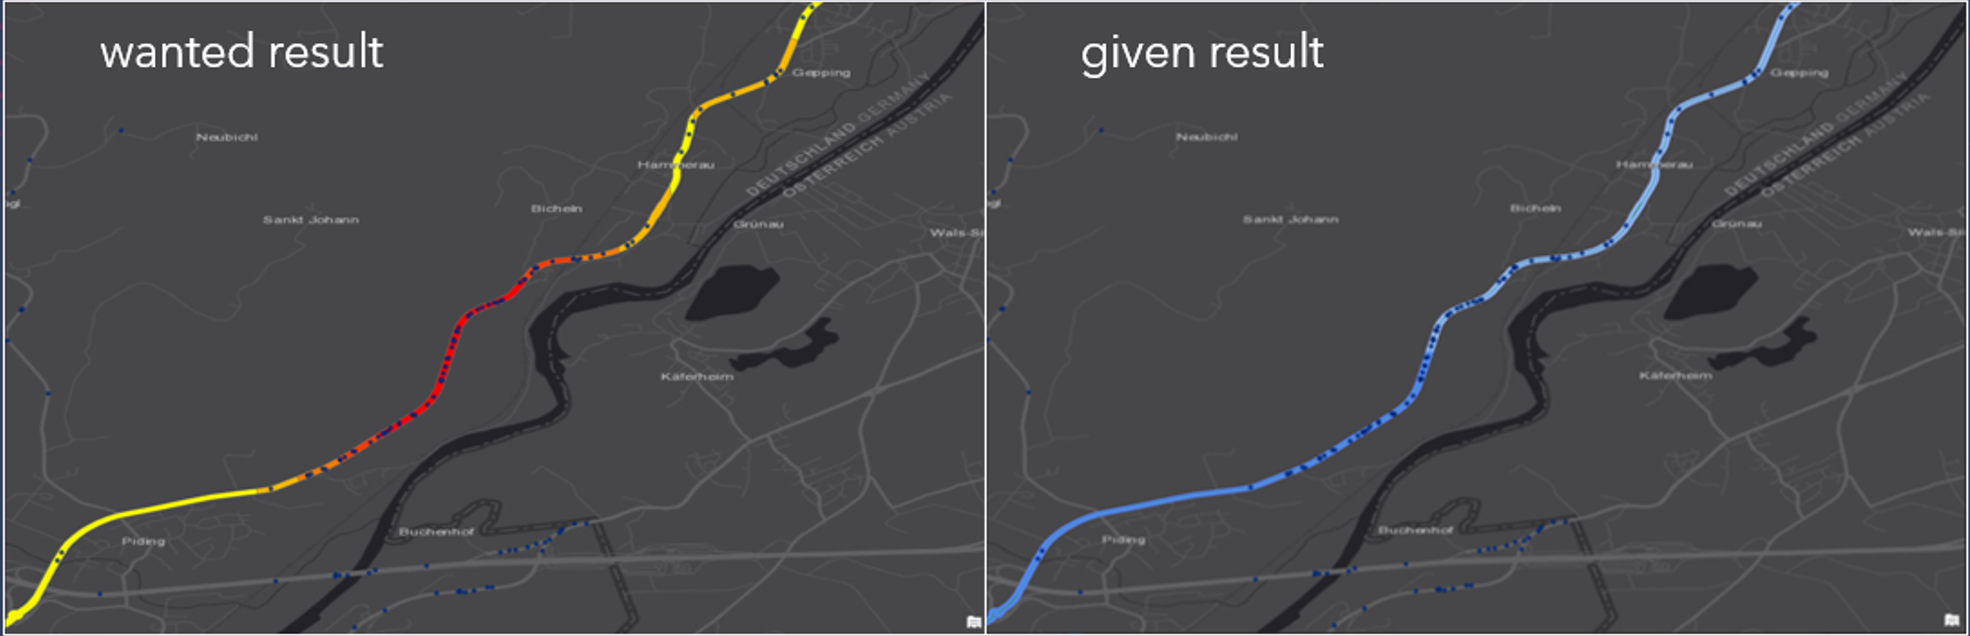